In [1]:
%load_ext autoreload
%autoreload 2|

### Imports

In [2]:
PYTHON_PATHS = [".."]
import sys
for path in PYTHON_PATHS:
    if path not in sys.path:
        sys.path.append(path)

import torch
import torch.nn as nn
import pytorch_lightning as pl
from torchvision.io import read_image

import rosbag
from sensor_msgs.msg import Image
from cv_bridge import CvBridge

from data_loader.orb_features_dataset import ORBFeaturesDataset
from data_loader.orb_features_data_module import ORBFeaturesDataModule
from classifier.resnet18 import Resnet18Model

import numpy as np
from tqdm.notebook import tqdm
import cv2
from matplotlib import pyplot as plt

### Model & Checkpoint Loading

In [3]:
model = Resnet18Model.load_from_checkpoint("orb-classifier-8.ckpt", 
                                           in_size=512, hidden_sizes=[512], out_size=2)

model = model.cpu()
model = model.eval()

Using cache found in /home/nuke/.cache/torch/hub/pytorch_vision_v0.10.0


network head
Sequential(
  (0): Linear(in_features=512, out_features=512, bias=True)
  (1): ReLU()
  (2): Linear(in_features=512, out_features=512, bias=True)
  (3): ReLU()
  (4): Linear(in_features=512, out_features=2, bias=True)
)


In [4]:
bridge = CvBridge()

In [6]:
def read_dataset_img(img_path, tranform):
    image = read_image(img_path)[None, ...]
    return tranform(image)

In [ ]:
# bag = rosbag.Bag("/media/nuke/nuke-ssd/hermesbot/datasets/omni-slam/raw_bags/2022-02-25-16-15-51.bag")
# bag = rosbag.Bag("/media/nuke/nuke-ssd/hermesbot/datasets/with_lidar_20220609/cameras.bag")
bag = rosbag.Bag("/media/nuke/nuke-ssd/hermesbot/datasets/with_lidar_20220610/2022-06-10-12-48-50.bag")
results = {}
for cam_num in tqdm(range(6)):
    tstamps = []
    outs = []
    res_small = {}
    for topic, msg, t in tqdm(bag.read_messages(topics=['/cam' + str(cam_num) + '/image_raw']), leave=False, total=bag.get_message_count('/cam' + str(cam_num) + '/image_raw')):
        cv_image = bridge.imgmsg_to_cv2(msg, desired_encoding='passthrough')
        cv2.imwrite("test.jpg", cv_image)
        img = read_dataset_img("test.jpg", model.transform)
        outs.append(torch.nn.functional.softmax(model.forward(img), dim=1).detach().cpu().numpy()[0][1])
        tstamps.append(t.to_nsec())
    res_small['t'] = tstamps
    res_small['r'] = outs
    results[str(cam_num)] = res_small

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/15319 [00:00<?, ?it/s]

  0%|          | 0/15319 [00:00<?, ?it/s]

  0%|          | 0/15319 [00:00<?, ?it/s]

### Plot Results

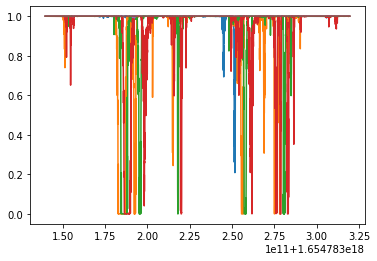

In [37]:
for i in range(6):
    plt.plot(results[str(i)]['t'], results[str(i)]['r'])
plt.show()

### Save results as CSV

In [41]:
for i in range(6):
    with open("outputs_cam" + str(i) + ".csv", 'w') as f:
        t = results[str(i)]['t']
        r = results[str(i)]['r']
        f.write('nsecs, output\n')
        for j in range(len(t)):
            f.write(str(t[j]) + ', ' + str(r[j]) + '\n')


In [ ]:
cv_image2 = np.moveaxis(cv_image, 0, -1)

plt.imshow(cv_image2)

In [ ]:
dataset_params = {'root': "/media/nuke/nuke-ssd/hermesbot/datasets/omni-slam/", 
                  'datasets': [
#                               "dataset_1_cam_0",
                              # "dataset_1_cam_1",
                              # "dataset_1_cam_2",
                              # "dataset_1_cam_3",
                              "dataset_2_cam_5"
                             ],
                  'classification_threshold': 1,
                  'transform': model.transform,
                  'combine_data': False
                 }

dataset = ORBFeaturesDataset(**dataset_params)

In [ ]:
predictions = []

for d in tqdm(dataset.images_list):
    preds= []
    
    for img_path in d:
        img = read_dataset_img(img_path, model.transform)
        preds.append(torch.nn.functional.softmax(model.forward(img), dim=1).detach().cpu().numpy())
    predictions.append(preds)
    
labels = dataset.labels

In [ ]:
ress = [predictions[0][i][0][1] for i in range(len(predictions[0]))]

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
plt.plot(ress)